## 1. Generate Model and Data

### 1-1. Setup

In [10]:
import sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import tensorflow as tf
from   tensorflow import keras
import tf2onnx
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt

print("Scikit-learn version     : ", sklearn.__version__)
print("TensorFlow version       : ", tf.__version__)
print("Numpy version            : ", np.__version__)
print("Matplotlib.pyplot version: ", plt.matplotlib.__version__)
print("tf2onnx version          : ", tf2onnx.__version__)
print("idx2numpy vresion        : ", idx2numpy.__version__)

Scikit-learn version     :  1.2.2
TensorFlow version       :  2.11.0
Numpy version            :  1.25.0
Matplotlib.pyplot version:  3.7.1
tf2onnx version          :  1.14.0
idx2numpy vresion        :  1.2.3


### 1-2. Dataset loading & processing

In [12]:
# load data from scikit-learn library
iris = load_iris()
# onehot coding labels 
label_oneHot = tf.one_hot(iris.target, len(set(iris.target))).numpy()
# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, label_oneHot, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 4) (30, 4) (120, 3) (30, 3)


### 1-3. Model building and training

In [31]:
# 2 hidden layers with relu
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3)
  ])

# set optimizer, loss function, and evaluation metrics 
model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model training
model.fit(X_train, y_train, batch_size=1, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
120/120 [==============================] - 3s 20ms/step - loss: 1.2145 - accuracy: 0.3250 - val_loss: 0.9616 - val_accuracy: 0.3667
Epoch 2/50
120/120 [==============================] - 2s 13ms/step - loss: 0.9054 - accuracy: 0.4250 - val_loss: 0.7936 - val_accuracy: 0.7000
Epoch 3/50
120/120 [==============================] - 1s 10ms/step - loss: 0.7338 - accuracy: 0.7833 - val_loss: 0.6202 - val_accuracy: 0.7000
Epoch 4/50
120/120 [==============================] - 1s 11ms/step - loss: 0.5799 - accuracy: 0.8167 - val_loss: 0.4971 - val_accuracy: 0.9000
Epoch 5/50
120/120 [==============================] - 2s 16ms/step - loss: 0.4790 - accuracy: 0.9083 - val_loss: 0.4162 - val_accuracy: 0.9000
Epoch 6/50
120/120 [==============================] - 1s 8ms/step - loss: 0.4142 - accuracy: 0.9417 - val_loss: 0.3634 - val_accuracy: 1.0000
Epoch 7/50
120/120 [==============================] - 1s 8ms/step - loss: 0.3646 - accuracy: 0.9417 - val_loss: 0.3325 - val_accuracy: 1.0000
E

### 1-4. Test Accuracy

In [32]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy on test data: ", accuracy)
print("Loss on test data    : ", loss)

1/1 [==============================] - 0s 160ms/step - loss: 0.1029 - accuracy: 0.9333
Accuracy on test data:  0.9333333373069763
Loss on test data    :  0.10291294753551483


### 1-5. Convert model to onnx, data to idx

In [33]:
# convert model to onnx
onnx_model, _ = tf2onnx.convert.from_keras(model, output_path="network.onnx")
# convert data to idx
idx2numpy.convert_to_file('iris_x.idx', X_test)
idx2numpy.convert_to_file('iris_y.idx', y_test)
# idx2numpy.convert_to_file('iris_test_y_1d.idx', np.argmax(y_test, axis=1).astype(np.int32))

## 2. Explore data (to decide logical specification)

### 2-1. Check range of input features

In [16]:
# get min, max
min_values = np.min(iris.data, axis=0)
max_values = np.max(iris.data, axis=0)
print(min_values, max_values)

[4.3 2.  1.  0.1] [7.9 4.4 6.9 2.5]


In [17]:
# get mean, std
mean_values = np.mean(iris.data, axis=0)
std_values = np.std(iris.data, axis=0)
print(mean_values, std_values)

[5.84333333 3.05733333 3.758      1.19933333] [0.82530129 0.43441097 1.75940407 0.75969263]


### 2-2. Draw scatter plots

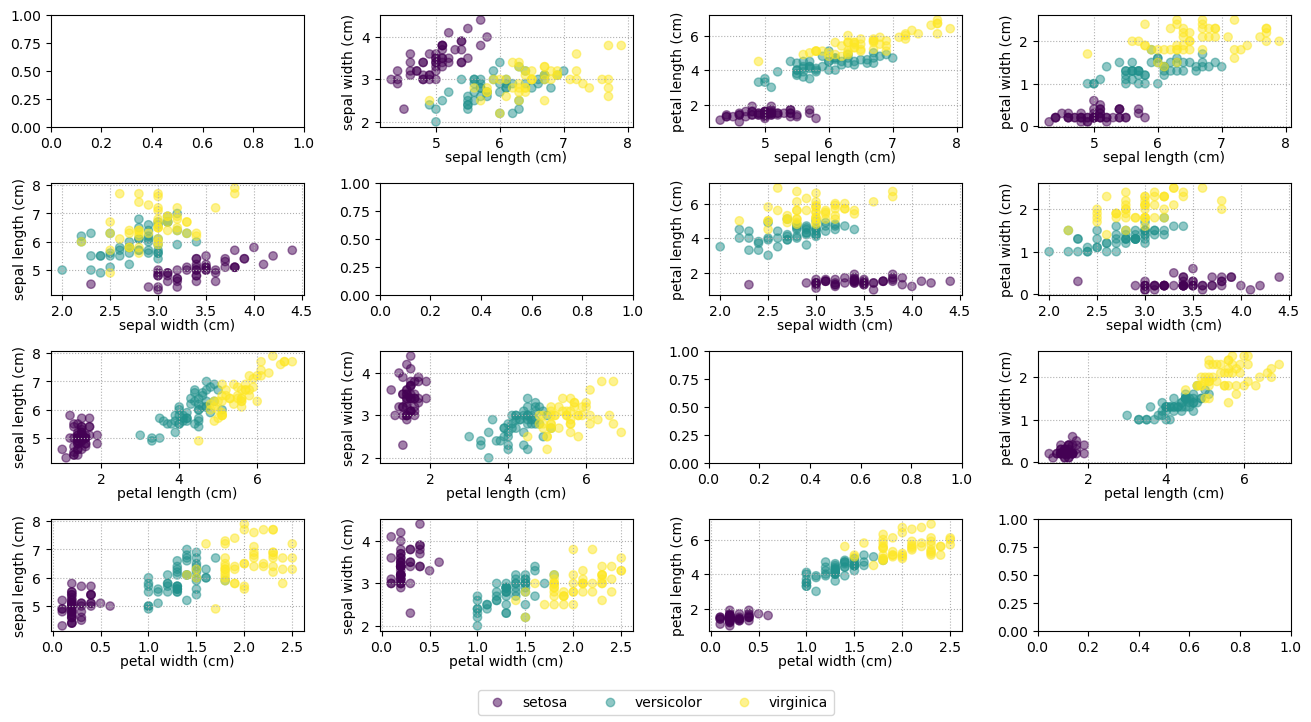

In [18]:
n_features = iris.data.shape[1]

# create subplots for each pair of features
fig, axs = plt.subplots(n_features, n_features, figsize=(16, 8))

# iterate over each pair of features
for i in range(n_features):
    for j in range(n_features):
        # skip diagonal plots 
        if i == j:
            continue    
        ax = axs[i, j]
        scatter = ax.scatter(iris.data[:, i], iris.data[:, j], c=iris.target, label=iris.target_names, alpha=0.5)
        ax.grid(True, linestyle='dotted')
        ax.set_xlabel(iris.feature_names[i], labelpad=0)
        ax.set_ylabel(iris.feature_names[j])
        
# get unique class labels and handles from the scatter plot
handles, labels = scatter.legend_elements()

# Create a single legend for the entire plot
fig.legend(handles, iris.target_names, loc='lower center', ncol=4)

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Save the plot
plt.savefig('scatterPlot_whole.png', dpi=300, bbox_inches='tight')
plt.show()

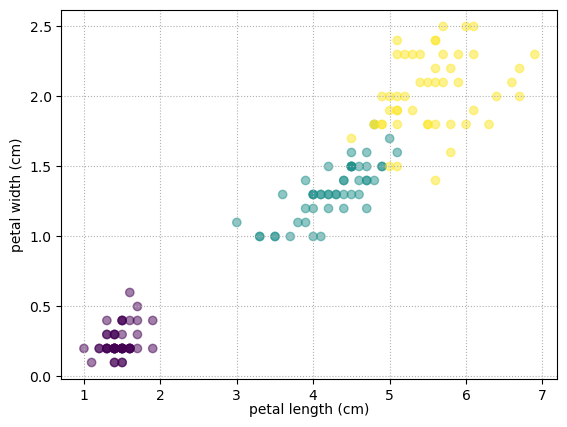

In [39]:
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=iris.target, label=iris.target_names, alpha=0.5)
plt.grid(True, linestyle='dotted')
plt.xlabel(iris.feature_names[2], labelpad=0)
plt.ylabel(iris.feature_names[3])

plt.savefig('scatterPlot_feature23.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
plt.scatter(iris.data[:, 1], iris.data[:, 2], c=iris.target, label=iris.target_names, alpha=0.5)
plt.grid(True, linestyle='dotted')
plt.xlabel(iris.feature_names[1], labelpad=0)
plt.ylabel(iris.feature_names[2])

plt.savefig('scatterPlot_feature12.png', dpi=300, bbox_inches='tight')
plt.show()

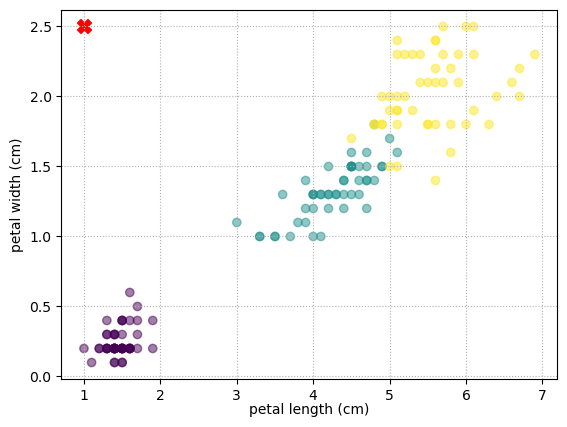

In [41]:
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=iris.target, label=iris.target_names, alpha=0.5)

# Add a specific marker at the point (x, y)
specific_x = 1.0  # Replace with your specific x-coordinate
specific_y = 2.5  # Replace with your specific y-coordinate
plt.scatter(specific_x, specific_y, marker='X', color='red', s=100, label='Specific Point')

plt.grid(True, linestyle='dotted')
plt.xlabel(iris.feature_names[2], labelpad=0)
plt.ylabel(iris.feature_names[3])

plt.savefig('scatterPlot_feature23_x.png', dpi=300, bbox_inches='tight')
plt.show()

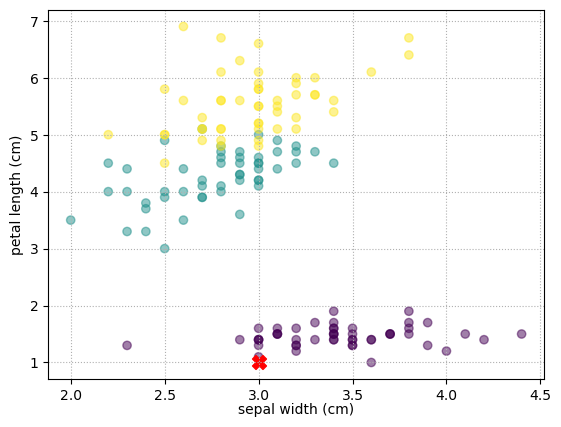

In [42]:
plt.scatter(iris.data[:, 1], iris.data[:, 2], c=iris.target, label=iris.target_names, alpha=0.5)

# Add a specific marker at the point (x, y)
specific_x = 3.0  # Replace with your specific x-coordinate
specific_y = 1.0  # Replace with your specific y-coordinate
plt.scatter(specific_x, specific_y, marker='X', color='red', s=100, label='Specific Point')

plt.grid(True, linestyle='dotted')
plt.xlabel(iris.feature_names[1], labelpad=0)
plt.ylabel(iris.feature_names[2])

plt.savefig('scatterPlot_feature12_x.png', dpi=300, bbox_inches='tight')
plt.show()

### 2-3. Check relationships between features

In [20]:
# sepal length is always longer than sepal width
np.any(iris.data[:, 0] - iris.data[:, 1] > 0)

True

In [21]:
# petal length is always longer than petal width
np.any(iris.data[:, 2] - iris.data[:, 3] > 0)

True

### 2-4. Correlations between columns

In [22]:
correlation_matrix = np.corrcoef(X_train, rowvar=False)
correlation_matrix

array([[ 1.        , -0.10692625,  0.86217499,  0.80148008],
       [-0.10692625,  1.        , -0.4320886 , -0.36950859],
       [ 0.86217499, -0.4320886 ,  1.        ,  0.96257703],
       [ 0.80148008, -0.36950859,  0.96257703,  1.        ]])

#### 2-4-1. Get linear function between feature 3 and 4 (In high correlation)

In [23]:
from sklearn.linear_model import LinearRegression

# extracts X and y (petalLength and petalWidth)
petalLength = X_train[:, 2].reshape(-1, 1)
petalWidth = X_train[:, 3]

# fit linear regression model
regressor = LinearRegression()
regressor.fit(petalLength, petalWidth)

# get coefficients (slope and intercept)
slope = regressor.coef_[0]
intercept = regressor.intercept_

print(slope, intercept)

0.4132382936645491 -0.35666804105655303


#### 2-4-2. Get range of errors (y - y_pred)

In [24]:
errors = regressor.predict(petalLength) - petalWidth
print(max(errors), min(errors))

0.5574664034649219 -0.6491527433673527
